<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Correlations and their significance with `Pyleoclim`

## Authors

Julien Emile-Geay, USC Earth Sciences

Feng Zhu, NUIST

Author1 = {"name": "Julien Emile-Geay", "affiliation": "Department of Earth Sciences, University of Southern California", "email": "julieneg@usc.edu", "orcid": "0000-0001-5920-4751"}

Author2 = {"name": "Feng Zhu", "affiliation": "Nanjing University of Information Science and Technology", "email": "fzhu@nuist.edu", "orcid": "0000-0002-9969-2953"}


## Preamble
### Introduction 

Correlation analysis, despite its simplicity and many shortcomings, remains a centerpiece of empirical analysis in many fields, particularly the paleosciences. Computing correlations is trivial enough; the difficulty lies in properly assessing their significance. Of particular importance are three considerations:
- **Persistence**, which violates the standard assumption that the data are independent (which underlies the classical test of significance implemented, e.g. in Excel). 
- **Time irregularities**, for instance comparing two records with different time axes, possibly unevenly spaced (which standard software cannot deal with out of the box)
- **Test multiplicity** aka the "Look Elsewhere effect", which states that repeatedly performing the same test can result in unacceptably high type I error (accepting correlations as significant, when in fact they are not). This arises e.g. when correlating a paleoclimate record with an instrumental field, assessing significance at thounsands of grid points at once, or assessing significance within an age ensemble.

Accordingly,  `Pyleoclim` facilitates an assessment of correlations that deals with all these cases, makes the necessary data transformations transparent to the user, and allows for one-line plot commands to visualize the results. 


### Goals 
In this notebook, we illustrate some of these capabilities with several simple scenarios, including:
1. Correlating a single `Series` object with another, with different time axes
1. Correlating a single `Series` object with a gridded field (using `MultipleSeries`)
1. Correlating a single `Series` object with a `EnsembleSeries`
1. Correlating two `EnsembleSeries` objects together

For a primer on these data structures, see the [documentation](https://pyleoclim-util.readthedocs.io/en/master/core/api.html).

**Reading Time: 20 min**

**Running Time**: several hours due to large SST grid

### Keywords
Correlations, Surrogates, Significance, Visualization 

### Pre-requisites
some basics statistics

### Relevant Packages
pyleoclim, matplotlib, xarray, cartopy


## Data Description and Processing
- Coral Sr/Ca series (a proxy for sea-surface temperature) by [Nurhati et al (2011)](https://doi.org/10.1175/2011JCLI3852.1). The data are from Palmyra Island in the tropical Pacific, at the edge of the NINO3.4 box (a popular measure of the state of El Niño Southern Oscillation). 
- Sea-surface temperature analysis of ERSSTv5 [(Huang et al, 2017)](https://10.1175/JCLI-D-16-0836.1)


In [147]:
import pyleoclim as pyleo
pyleo.set_style('web')
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

First let's load the coral data:

In [2]:
d = pyleo.Lipd('../data/Ocn-Palmyra.Nurhati.2011.lpd')

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Ocn-Palmyra.Nurhati.2011.lpd
Finished read: 1 record


extracting paleoData...
extracting: Ocn-Palmyra.Nurhati.2011
Created time series: 5 entries


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Year [AD]', ylabel='Sr_Ca [mmol/mol]'>)

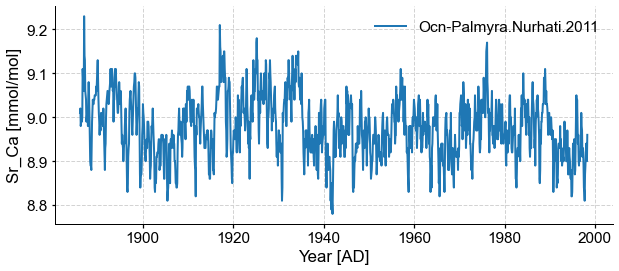

In [4]:
srca = d.to_LipdSeries(number=2) # load only the Sr/Ca observations
srca.plot()

Next we load the ERSSTv5 data. Note that the actual dat are not being transferred over the network yet ; all we are getting is a pointer towards a netCDF file on a NOAA [THREDDS](https://docs.unidata.ucar.edu/tds/4.6/adminguide/) server. The real crunching will come later.

In [8]:
filepath = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ersstv5 = xr.open_dataset(filepath)
ersstv5

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 2023)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-07-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max:              359.0
    geospatial_laty_max:             89.0
    geospatial_laty_min:             -89.0
    geospatial_lat_max:              89.0
    geospatial_lat_min:              -89.0
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    cdm_data_type:                   Grid
    project:                         NOAA Extended Reconstructed Sea Surface ...
    original_publisher_url:          http://www.ncdc.noaa.gov
    References:                      https://www.ncdc.noaa.gov/data-access/ma...
    source:                          In situ data: ICOADS R3.0 before 2015, N...
    title:                           NOAA ERSSTv5 (in situ only)
    history:                         created 07/2017 by PSD data using NCEI's...
    institution:                     This version written at NOAA/ESRL PSD: o...
    citation:                        Huang et al, 2017: Extended Reconstructe...
    platform:                        Ship and Buoy SSTs from ICOADS R3.0 and ...
    standard_name_vocabulary:        CF Standard Name Table (v40, 25 January ...
    processing_level:                NOAA Level 4
    Conventions:                     CF-1.6, ACDD-1.3
    metadata_link:                   :metadata_link = https://doi.org/10.7289...
    creator_name:                    Boyin Huang (original)
    date_created:                    2017-06-30T12:18:00Z (original)
    product_version:                 Version 5
    creator_url_original:            https://www.ncei.noaa.gov
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-08-07
    DODS_EXTRA.Unlimited_Dimension:  time

Let's select a smaller portion of this dataset to correlate with the Sr/Ca record:

In [18]:
ersstv5_tp = ersstv5.sel(lat=slice(40, -10), lon=slice(120, 280))
ersstv5_tp

<xarray.Dataset>
Dimensions:    (lat: 26, lon: 91, nbnds: 2, time: 2023)
Coordinates:
  * lat        (lat) float32 40.0 38.0 36.0 34.0 32.0 ... -4.0 -6.0 -8.0 -10.0
  * lon        (lon) float32 110.0 112.0 114.0 116.0 ... 284.0 286.0 288.0 290.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-07-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 ...
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max:              359.0
    geospatial_laty_max:             89.0
    geospatial_laty_min:             -89.0
    geospatial_lat_max:              89.0
    geospatial_lat_min:              -89.0
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    cdm_data_type:                   Grid
    project:                         NOAA Extended Reconstructed Sea Surface ...
    original_publisher_url:          http://www.ncdc.noaa.gov
    References:                      https://www.ncdc.noaa.gov/data-access/ma...
    source:                          In situ data: ICOADS R3.0 before 2015, N...
    title:                           NOAA ERSSTv5 (in situ only)
    history:                         created 07/2017 by PSD data using NCEI's...
    institution:                     This version written at NOAA/ESRL PSD: o...
    citation:                        Huang et al, 2017: Extended Reconstructe...
    platform:                        Ship and Buoy SSTs from ICOADS R3.0 and ...
    standard_name_vocabulary:        CF Standard Name Table (v40, 25 January ...
    processing_level:                NOAA Level 4
    Conventions:                     CF-1.6, ACDD-1.3
    metadata_link:                   :metadata_link = https://doi.org/10.7289...
    creator_name:                    Boyin Huang (original)
    date_created:                    2017-06-30T12:18:00Z (original)
    product_version:                 Version 5
    creator_url_original:            https://www.ncei.noaa.gov
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-08-07
    DODS_EXTRA.Unlimited_Dimension:  time

And let's plot that domain:

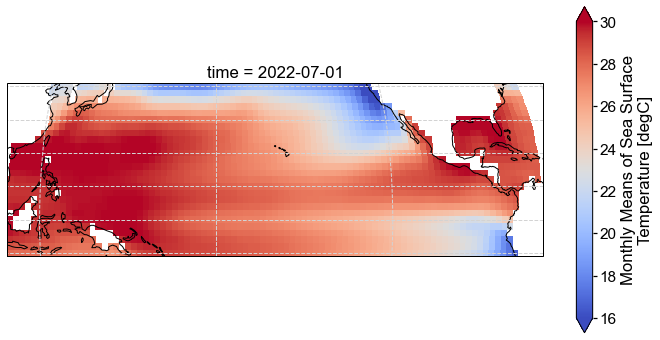

In [19]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
ersstv5_tp.sst.isel(time=-1).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=16, vmax=30, cmap='coolwarm'
);

Now extract the NINO3.4 index:

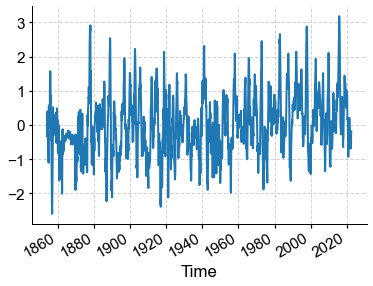

In [28]:
nino34_box = ersstv5_tp.sel(lat=slice(5, -5), lon=slice(190, 240))
gb = nino34_box.sst.groupby('time.month')
nino34_anom = gb - gb.mean(dim='time')
weights = np.cos(np.deg2rad(nino34_box.lat))
nino34 = nino34_anom.weighted(weights).mean(dim=['lat', 'lon'])
nino34.plot()

The date format is `datetime64`, which for the moment is not understood by Pyleoclim (it will be the case in a few releases, after pandas 1.5 is released and integrated into `pyleoclim`). We thus need to transform it to decimal years, thanks to [this little trick](https://stackoverflow.com/a/26895491/4984978).

In [59]:
dates = nino34['time'].values
years = dates.astype('datetime64[Y]').astype(int) + 1970
months = dates.astype('datetime64[M]').astype(int) % 12 + 1
decimal_year = years + months/12.0

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='NINO3.4 [$^\\circ$C]'>)

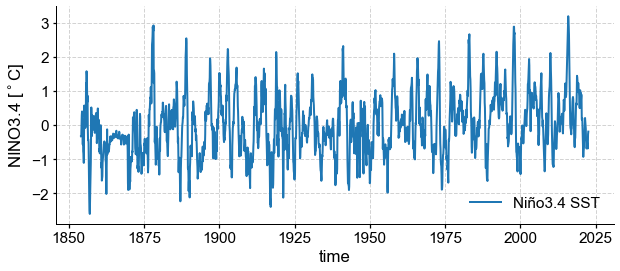

In [62]:
nino34ts = pyleo.Series(time = decimal_year, value = nino34.values, value_name='NINO3.4',
                        value_unit= '$^\circ$C', label='Niño3.4 SST')
nino34ts.plot()

Now we can compute correlations between the Nurhati et al (2011) Sr/Ca dataset and NINO3.4.
## Demonstration

### The Corr object

In [63]:
corr1a = srca.correlation(nino34ts)
print(corr1a)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
    -0.443165  < 1e-6     True



The output of `correlation()` is a [Corr object](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#corr-pyleoclim-corr), which is set up so that the standard `print()` function that nicely formats the P-value and lets you know if it is significant or not.  In this case, a value of $10^{-6}$ means that the observed correlation of -0.44 is larger (in absolute value) than expected from the vast majority of samples under the null hypothesis.  

Also, note that `correlation()` is symmetric, as corr(A,B) = corr(B,A):

In [65]:
corr1b = nino34ts.correlation(srca)
print(corr1b)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
    -0.443165  < 1e-6     True



### Pairwise Correlations Three Ways

What does "significant" mean here?
Pyleoclim support 3 null models for this significance assessment:
1. a parametric T-test adjusted for the effect of autocorrelation (`ttest`)
1. a  Monte Carlo test against surrogate series that have the same persistence properties as the original series (`isopersistent`)
1. a Monte Carlo test against surrogate series that have the same spectrum as the original series (`isospectral`; this is the default)

The standard null model for correlations in the statistical literature is a Student's t test, which assumes that the data are [IID](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). The independence assumption is often violated by the persistence of most climate timeseries, particularly the ones shown above. `pyleoclim` thus implements a modified version of the classical T-test, one that adjusts for the loss of degrees of freedom due to persistence as per Dawdy & Matalas (1964):

In [66]:
corr1t = srca.correlation(nino34ts, settings={'method':'ttest'})
print(corr1t)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
    -0.443165  < 1e-6     True



In [67]:
corr1_isopersist = srca.correlation(nino34ts, settings={'method':'isopersistent'}, seed = 2333)
print(corr1_isopersist)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
    -0.443165  < 1e-41    True



Because this is a simulation-based method, the result will depent on the number of simulations, `nsim`.  Upping `nsim` ensures more consistent results, though in this case the result does not change: 

In [69]:
corr1_isopersist = srca.correlation(nino34ts, settings={'method':'isopersistent','nsim': 5000}, seed = 2333)
print(corr1_isopersist)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
    -0.443165  < 1e-58    True



We see that the p-value changes subtly between these two cases, but not enough to change the result (the correlation is  significant either way). However, to ensure that these sampling issues won't affect the reproducibility of the results, we specify a [random seed](https://en.wikipedia.org/wiki/Random_seed). Note that the difference between “significant” and “not significant” p-values is not itself statistically significant [(Gelman & Stern, 2006)](https://doi.org/10.1198/000313006X152649). 

The last null model method is `isospectral`, which phase-randomizes the original signals, thereby preserving the spectrum of each series but scrambling phase relations between the signals. This (non-paramettric) method was first proposed by [Ebisuzaki (1997)](http://dx.doi.org/10.1175/1520-0442(1997)010%3C2147:AMTETS%3E2.0.CO;2), and is called _isospectral_ because it leaves the spectrum (and therefore the autocorrelation function) intact. Since, this is also a simulation method, one can also play with the number of simulations, as done here:

In [71]:
corr1_isospec = srca.correlation(nino34ts, settings={'method':'isospectral','nsim': 5000}, seed = 4343)
print(corr1_isospec)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
    -0.443165  < 1e-6     True



We see that this resulted is a modestly different p-value, but again one far below 5%, which leads to rejection of the null hypothesis (the correlation is deemed significant at the 5% level, and would pass that test for much lower $\alpha$ levels as well). Because it makes the fewest assumptions, this is the default method.

In this case, the three methods concur that the correlation is significant; this may not always be the case, so we encourage users to play with these methods in case they obtain p-values close to the test level, to discourage p-hacking temptations. 

### Field correlations

The previous section shows how to properly assess significance between two series. The situation becomes more complex as one  conducts a similar test between a paleoclimate timeseries and collection of series, for instance coming from a gridded field. To see why, let us recursively carry out the same test as above at all ERSSTv5 North Pacific grid points. For this, we need not only to loop over grid points, but also store the p-values for later analysis. 

In [73]:
ersstv5_tp

<xarray.Dataset>
Dimensions:    (lat: 26, lon: 91, nbnds: 2, time: 2023)
Coordinates:
  * lat        (lat) float32 40.0 38.0 36.0 34.0 32.0 ... -4.0 -6.0 -8.0 -10.0
  * lon        (lon) float32 110.0 112.0 114.0 116.0 ... 284.0 286.0 288.0 290.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-07-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 ...
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max:              359.0
    geospatial_laty_max:             89.0
    geospatial_laty_min:             -89.0
    geospatial_lat_max:              89.0
    geospatial_lat_min:              -89.0
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    cdm_data_type:                   Grid
    project:                         NOAA Extended Reconstructed Sea Surface ...
    original_publisher_url:          http://www.ncdc.noaa.gov
    References:                      https://www.ncdc.noaa.gov/data-access/ma...
    source:                          In situ data: ICOADS R3.0 before 2015, N...
    title:                           NOAA ERSSTv5 (in situ only)
    history:                         created 07/2017 by PSD data using NCEI's...
    institution:                     This version written at NOAA/ESRL PSD: o...
    citation:                        Huang et al, 2017: Extended Reconstructe...
    platform:                        Ship and Buoy SSTs from ICOADS R3.0 and ...
    standard_name_vocabulary:        CF Standard Name Table (v40, 25 January ...
    processing_level:                NOAA Level 4
    Conventions:                     CF-1.6, ACDD-1.3
    metadata_link:                   :metadata_link = https://doi.org/10.7289...
    creator_name:                    Boyin Huang (original)
    date_created:                    2017-06-30T12:18:00Z (original)
    product_version:                 Version 5
    creator_url_original:            https://www.ncei.noaa.gov
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-08-07
    DODS_EXTRA.Unlimited_Dimension:  time

In [88]:
nlon = len(ersstv5_tp['lon'])
nlat = len(ersstv5_tp['lat']) 
pval = np.empty((nlon,nlat)) # declare array to store pvalues
corr = np.empty_like(pval) # declare empty array of identical shape
slon, slat = [], [];
sst_list = [] # initialize empty list 
alpha = 0.05

for ji in range(nlon):
    print("Computing correlations at " + str(ersstv5_tp.lon[ji].values) + 'E')
    for jj in range(nlat):  
        st = ersstv5_tp['sst'][:,jj,ji]
        #  locate valid ocean points
        noNaNs = len(np.where(np.isnan(st) == False)[0]) # number of valid years
        sstvar = st.var()  # variance
        if noNaNs >= 100 and sstvar >= 0.01:
            sttb = pyleo.Series(time=decimal_year,
                        time_unit = 'year CE', 
                        value = st.values, #st_annual.values,
                        value_unit = 'C',clean_ts=False)
            sst_list.append(sttb) 
            corr_res = sttb.correlation(srca, settings={'method':'isospectral','nsim':200},seed=333)
            pval[ji,jj] = corr_res.p
            corr[ji,jj] = corr_res.r
            if pval[ji,jj] < alpha:
                slon.append(ersstv5_tp.lon[ji])
                slat.append(ersstv5_tp.lat[jj])
        else:  
            pval[ji,jj] = np.nan; corr[ji,jj] = np.nan

Computing correlations at 110.0E
Computing correlations at 112.0E
Computing correlations at 114.0E
Computing correlations at 116.0E
Computing correlations at 118.0E
Computing correlations at 120.0E
Computing correlations at 122.0E
Computing correlations at 124.0E
Computing correlations at 126.0E
Computing correlations at 128.0E
Computing correlations at 130.0E
Computing correlations at 132.0E
Computing correlations at 134.0E
Computing correlations at 136.0E
Computing correlations at 138.0E
Computing correlations at 140.0E
Computing correlations at 142.0E
Computing correlations at 144.0E
Computing correlations at 146.0E
Computing correlations at 148.0E
Computing correlations at 150.0E
Computing correlations at 152.0E
Computing correlations at 154.0E
Computing correlations at 156.0E
Computing correlations at 158.0E
Computing correlations at 160.0E
Computing correlations at 162.0E
Computing correlations at 164.0E
Computing correlations at 166.0E
Computing correlations at 168.0E
Computing 

In [114]:
pvals = pval.flatten() # make the p-value array a 1D one
nt = len(pvec)
print(str(nt)) # check on the final number
len(slon)

2083


989

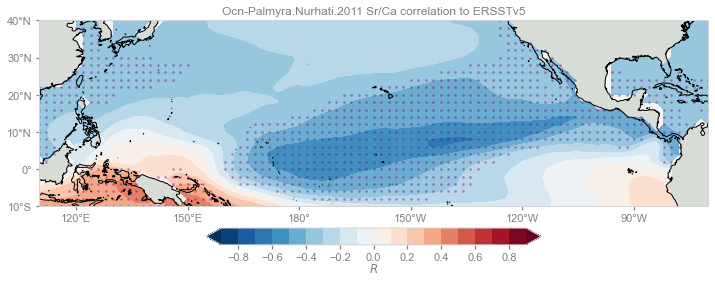

In [159]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns

land_color=sns.xkcd_rgb['light grey']
lon_min, lon_max, lat_min, lat_max = (110, 290, -10, 40)
lon_ticks = np.arange(120, 330, 30)
lat_ticks = np.arange(-10, 50, 10)

# map
fig = plt.figure(figsize=[12, 8])
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.LAND, facecolor=land_color, edgecolor=land_color)
ax.coastlines()
transform = ccrs.PlateCarree()

ax.set_extent(latlon_range, crs=transform)
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
mask_lon = (lon_ticks >= lon_min) & (lon_ticks <= lon_max)
mask_lat = (lat_ticks >= lat_min) & (lat_ticks <= lat_max)
ax.set_xticks(lon_ticks[mask_lon], crs=transform)
ax.set_yticks(lat_ticks[mask_lat], crs=transform)

# contour
clevs = np.linspace(-0.9, 0.9, 19)
im = ax.contourf(ersstv5_tp.lon, ersstv5_tp.lat, corr.T, clevs, transform=transform, cmap='RdBu_r', extend='both')

# significant points
plt.scatter(x=slon, y=slat, color="purple", s=3, alpha=0.3, transform=transform) 
plt.title(srca.label +' Sr/Ca correlation to ERSSTv5')
# colorbar
#plt.rcParams['axes.grid'] = False  # necessary in MPL 3.5.x https://github.com/matplotlib/matplotlib/issues/21723
cbar = fig.colorbar(im, ax=ax, pad=0.05, aspect=20, orientation = 'horizontal', fraction=0.15, shrink=0.5)
cbar.set_label(r'$R$', labelpad=-1)

The purple dots on the map are the locations of the gridpoints where the p-values fall under 5%, and they naturally correspond to the regions of highest (absolute) correlations, here negative because of the well-known temperature-dependent substitution of trace elements in the crystal lattice: the Sr/Ca ratio decreases with increasing temperature. The pattern is reminiscent of the North Pacific Gyre Oscillation, as found in [Nurhati et al (2011)](https://doi.org/10.1175/2011JCLI3852.1). 


Are these correlatons all "significant", in the sense of being remarkable? Here we must account for the Multiple Hypothesis problem, otherwise known as the "look elsewhere" effect. Conducting tests at the 5% level (what most people would call "the 95% confidence level") specifically means that we expect 5% of our tests to return spurious results, just from chance alone (the so-called "type I error"). We just carried out 2083 tests, so we expect $0.05*327 \approx 104 $ of those results to be false positives, right out of the gate. So which of the 989 tests labeled as significant can we trust? 

One solution to this is the False Discovery Rate (aka **FDR**), which was devised in a celebrated paper [(Benjamini & Hochberg, 1995)](https://doi.org/10.1111/j.2517-6161.1995.tb02031.x). The idea is to look not just for the p-values under 5% (purple dots in the figure above), but for the fraction of those under the $0.05*i/m$, which guards against the false discoveries one expects out of repeatedly testing the same hypothesis over and over again. 


The idea is as follows: a multiple testing procedure returns a list of $p$-values.
With the traditional false positive test, the significance level $\alpha=0.05$ is refered as the false positive rate (FPR), and we reject null hypothesis $H_0$ at all locations $p_i < \alpha$. In the original BH95 method, the nominal FDR, denoted by $q$, is defined as the rate we are willing to allow of false rejections out of all rejections, and is usually set to $5\%$. The BH95 procedure rejects $H_0$ in all cases $i$ for which $p_i \le p_k$, where $k = \max_{i=0,...,n} \{i: p_{(i)}\le q i/n \}$. For an illustration, see Fig 2 of [Hu et al (2017)](http://dx.doi.org/10.1016/j.epsl.2016.11.048).

To access this functionality in `pyleoclim` , simply invoke:

In [118]:
fdr_res = pyleo.utils.correlation.fdr(pvec)
len(fdr_res)

868

`fdr_res` is a list of indices of the grid points in question, which could be mapped. In this case, it's obvious that many gridpoints pass the test, so we can be confident that the record contains much information about temperature variability (analyzing exactly how and why is not the purpose of this notebook). There would be another way to approach the question of field correlations: if we correlate the `srca` [Series](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#series-pyleoclim-series) object with a [MultipleSeries](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#multipleseries-pyleoclim-multipleseries) object made up of the various grid point series. If you notice the loop above, we stashed each series into a variable called `sst_list`, which we can use now: 

Looping over 2085 Series in collection


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2085/2085 [13:39<00:00,  2.54it/s]


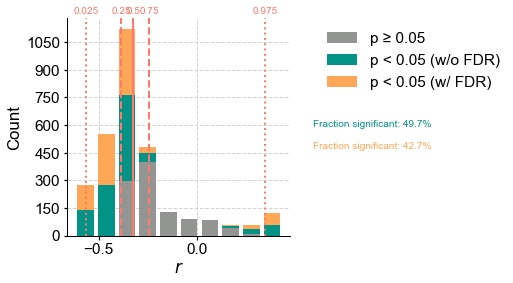

In [89]:
sstMS = pyleo.MultipleSeries(sst_list)
corrMS = sstMS.correlation(srca,settings={'method':'isospectral','nsim':1000},seed=333)   

In [153]:
type(corrMS)

pyleoclim.core.correns.CorrEns

The result is now a [CorrEns](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#correns-pyleoclim-correns) object, which has an additional `plot()` method:

891

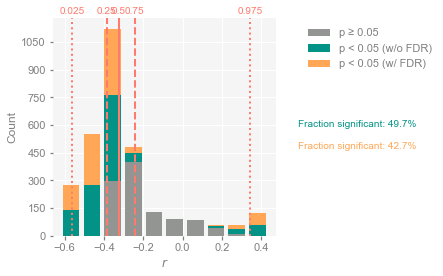

In [154]:
fig, ax = corrMS.plot()
corrMS.signif_fdr.count(True)

The gray bars indicate non-significant correlations, which tend to have low absolute values. Green bars locate all correlations with an associated p-value lower than 5% ; orange bars locate the fraction of those that pass the False Discovery Rate criterion (the 868 locales identified above). In addition to the `plot()` method used in the previous cell, this [CorrEns object](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#correns-pyleoclim-correns) also has a `print()` method, which formats the results nicely:

In [119]:
print(corrMS)

  correlation  p-value    signif. w/o FDR (α: 0.05)    signif. w/ FDR (α: 0.05)
-------------  ---------  ---------------------------  --------------------------
 -0.384839     < 1e-6     True                         True
 -0.388328     < 1e-6     True                         True
 -0.389754     < 1e-6     True                         True
 -0.381336     < 1e-2     True                         True
 -0.359468     < 1e-2     True                         True
 -0.338203     0.02       True                         True
 -0.329804     0.03       True                         False
 -0.333568     0.02       True                         True
 -0.33755      0.02       True                         True
 -0.340487     0.01       True                         True
 -0.206582     0.21       False                        False
 -0.0869658    0.54       False                        False
  0.0124136    0.90       False                        False
  0.17382      0.22       False                       

Note that the `correlation` method can also be applied to a `MultipleSeries` object without a target (`srca` was the target in the example above). In that case, the method proceeds by evaluating correlations (and their significance) between the first series in the collection and the rest of the list:

Looping over 2085 Series in collection


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2085/2085 [03:05<00:00, 11.23it/s]


(<Figure size 288x288 with 1 Axes>, <AxesSubplot:xlabel='$r$', ylabel='Count'>)

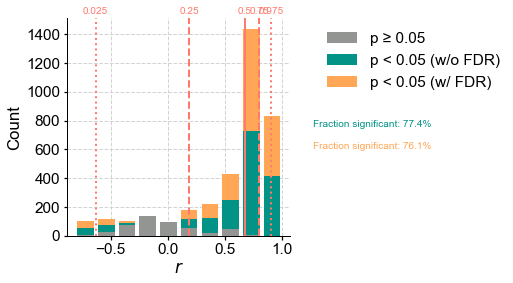

In [121]:
sstMS.correlation(settings={'method': 'isospectral', 'nsim': 200}).plot()

In [7]:
nt = np.size(ts_air_unevenly.time)
n_ens = 10  # ensemble size
ts_list = []
for i in range(n_ens):
    np.random.seed(i)
    noise = np.random.normal(loc=0, scale=2, size=nt)
    value = air_value_unevenly + noise
    new_ts = pyleo.Series(time=air_time_unevenly, value=value)
    ts_list.append(new_ts)
    
ms_air = pyleo.MultipleSeries(ts_list)
corr_res = ms_air.correlation()
# note here the target Series is not specified, and the 1st Series inside
# the MultipleSeries itself will be used as the target
print(corr_res)

{'r': [0.9999999999999998, 0.9999374125312044, 0.99993714372365, 0.9999344305144189, 0.9999415547035191, 0.9999395155655999, 0.9999375301231063, 0.9999391257891026, 0.9999343293322345, 0.9999376433287493], 'p': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'signif': [True, True, True, True, True, True, True, True, True, True]}


## Correlations with `EnsembleSeries` objects

Much like correlations between a Series and a `MultipleSeries` object, one can correlate Series and [EnsembleSeries](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#ensembleseries-pyleoclim-ensembleseries) objects. To quote the documentation: The EnsembleSeries object is a child of the MultipleSeries object, that is, a special case of MultipleSeries, aiming for ensembles of related series. Ensembles usually arise from age modeling or Bayesian calibrations. All members of an EnsembleSeries object are assumed to share identical labels and units.

In our field correlation case, we could have treated the grid points as an `EnsembleSeries` object, since they share the same time axis and units. However, we prefer to illustrate `EnsembleSeries` on a case more likely to arise in paleoclimatology: an ensemble of realizations from a noise model. 

Let's use the [gen_ts](https://pyleoclim-util.readthedocs.io/en/master/_modules/pyleoclim/utils/tsmodel.html?highlight=gen_ts#) function to generate some fractal noise (this is the default setting) and add it to 

In [135]:
n_ens = 100  # ensemble size
ts_list = []
for i in range(n_ens):
    _, noise = pyleo.utils.gen_ts(t=srca.time, model= 'colored_noise') 
    z, _, _ = pyleo.utils.standardize(noise)
    new_ts = pyleo.Series(time=srca.time, value=srca.value+z/10)
    ts_list.append(new_ts)
    
srcaEns = pyleo.EnsembleSeries(ts_list) # create ensemble series object

`EnsembleSeries` objects come with two methods unavailable to `MultipleSeries` objects: `plot_traces()` and `plot_envelope()`, the latter visualizing the quantiles of the ensemble through time. 

<AxesSubplot:xlabel='Year [AD]', ylabel='Sr_Ca [mmol/mol]'>

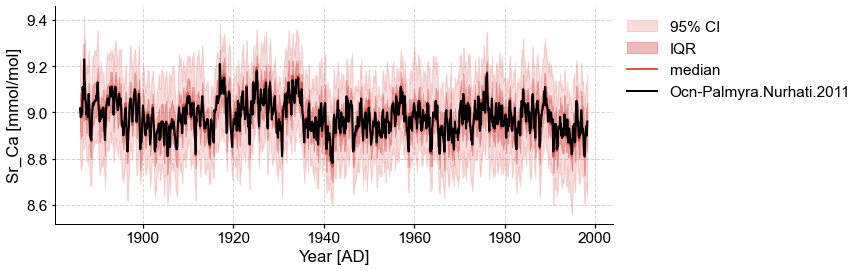

In [146]:
fig, ax = srcaEns.plot_envelope()
srca.plot(color='k',ax=ax, zorder=100, lgd_kwargs={'bbox_to_anchor': (1, 1)})

Looping over 100 Series in the ensemble


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.27it/s]


(<Figure size 288x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Correlation Ensemble'}, xlabel='$r$', ylabel='Count'>)

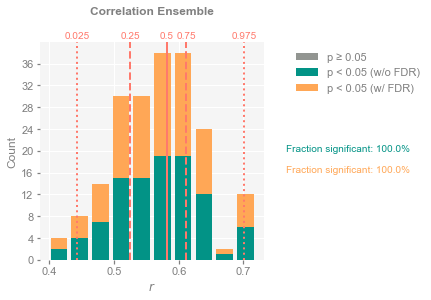

In [148]:
corrEns = srcaEns.correlation(srca)
corrEns.plot(title='Correlation Ensemble')

Non-surprisingly, all correlations are positive and significant, by construction. 

As with `MultipleSeries`, `correlation()` would also work on the `EnsembleSeries` object by itself (i.e. without specifying the target). 

### `EnsembleSeries` vs `EnsembleSeries`

FInally, we tackle the case of correlating two ensemble series objects. As before, we turn NINO3.4 into an ensemble by adding some noise to it, and to spice it up we use a different ensemble size. 

Suppose we name the two groups A and B, then the calculation of correlations will follow a pairwise procedure,
i.e., compare the 1st (2nd, 3rd, ...) member from A to the 1st (2nd, 3rd, ..) member from B, and stop when running out of members from either group.

In [150]:
n_ens = 50
ts_list = []
for i in range(n_ens):
    _, noise = pyleo.utils.gen_ts(t=nino34ts.time, model= 'colored_noise') 
    z, _, _ = pyleo.utils.standardize(noise)
    new_ts = pyleo.Series(time=nino34ts.time, value=nino34ts.value+z/10)
    ts_list.append(new_ts)
    
nino34Ens = pyleo.EnsembleSeries(ts_list) # create ensemble series object

Looping over 100 Series in the ensemble


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.47it/s]


(<Figure size 288x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Correlation: NINO3.4 vs Palmyra Sr/Ca Ensembles'}, xlabel='$r$', ylabel='Count'>)

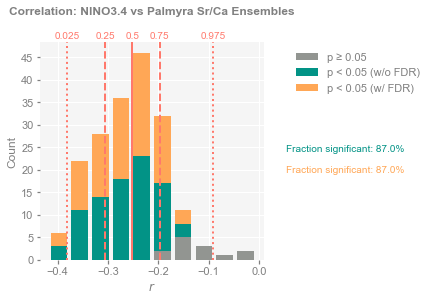

In [151]:
corrEns2 = srcaEns.correlation(nino34Ens)
corrEns2.plot(title='Correlation: NINO3.4 vs Palmyra Sr/Ca Ensembles')

## Takeaways

- `pyleoclim` allows to easily compute correlations between series with different time axes (including different resolutions).

- `pyleoclim` assesses significance with 3 different methods that are meant to guard against the deleterious effects of persistence, thereby lowering the risk of spurious correlations and [p-hacking](https://youtu.be/42QuXLucH3Q). 

- `pyleoclim` allows to compute correlations between a series and a collection of series, e.g. coming from a gridded field, addressing the Multiple Hypothesis Problem with the False Discovery Rate. 

- `pyleoclim` allows to compute correlations between, and within, `MultipleSeries` and `EnsembleSeries` object, using those same tools. 


## Acknowledgments

Project Pythia for [this notebook](https://foundations.projectpythia.org/core/xarray/enso-xarray.html) on xarray manipulations

## About `apply_fdr` in `EnsembleSeries.correlation()`

One major difference between `MultipleSeries.correlation()` and `EnsembleSeries.correlation()` is that the latter has the argument `apply_fdr=True` by default, which means that in an ensemble context, the FDR approach is to applied by default to determine whether the calculated p-values are significant. You can opt out of it by setting the flag to `False`, but not before carefully considering whether this is wise. 

Below we  explain the basic idea of FDR and demonstrate the use of `Pyleoclim`'s underlying FDR function with two simple tests to help understand the idea.

### Basic idea of FDR
Quoting from [Ventura et al. (2004)](https://journals.ametsoc.org/doi/full/10.1175/3199.1): "A single test performed at signiﬁcance level $\alpha$ has probability $\alpha$ of rejecting the null hypothesis when it is in fact true. Hence if $n$ such tests are performed when all $n$ null hypotheses are true (the collective null hypothesis), then the average number of tests for which the null is falsely rejected is $n\alpha$. For example, with $\alpha = 5\%$, testing for a trend at 1000 locations at which no change really occurred would yield 50 signiﬁcant locations on average; this is unacceptably high."

To overcome this disadvantage, there have been some alternatives, among which the enormously popular False Discovery Rate (FDR), introduced by Benjamini & Hochberg (1995) (BH95 hereafter). There are other variants such as Yekutieli & Benjamini (1999, 2001), and Ventura et al. (2004).

The idea is as follows: a multiple testing procedure, returns a list of $p$-values.
With the traditional false positive test, the significance level $\alpha=0.05$ is refered as the false positive rate (FPR), and we reject null hypothesis $H_0$ at all locations $p_i < \alpha$.

In the original BH95 method, the nominal FDR, denoted by $q$, is defined as the rate we are willing to allow of false rejections out of all rejections, and is usually set to $5\%$. The BH95 procedure rejects $H_0$ in all cases $i$ for which $p_i \le p_k$, where $k = \max_{i=0,...,n} \{i: p_{(i)}\le q i/n \}$. For an illustration, see Fig 2 of [Hu et al (2017)](http://dx.doi.org/10.1016/j.epsl.2016.11.048).

### The underlying FDR function in `Pyleoclim`

In [152]:
from pyleoclim.utils.correlation import fdr
?fdr

Signature: fdr(pvals, qlevel=0.05, method='original', adj_method=None, adj_args={})
Docstring:
Determine significance based on the false discovery rate

The false discovery rate is a method of conceptualizing the rate of type I errors in null hypothesis testing when conducting multiple comparisons. 
Translated from fdr.R by Dr. Chris Paciorek 

Parameters
----------

pvals : list or array
    A vector of p-values on which to conduct the multiple testing.

qlevel : float
    The proportion of false positives desired.

method : {'original', 'general'}
    Method for performing the testing.
        - 'original' follows Benjamini & Hochberg (1995);
        - 'general' is much more conservative, requiring no assumptions on the p-values (see Benjamini & Yekutieli (2001)).
        'original' is recommended, and if desired, using 'adj_method="mean"' to increase power.

adj_method: {'mean', 'storey', 'two-stage'}
    Method for increasing the power of the procedure by estimating the proportion 

#### Example case I

First let's generate a list of $p$-values with size 10 to emulate 10 tests.

In [12]:
np.random.seed(2333)
pval_list = np.random.random(10)/10
print('p-value list:\n', pval_list)

fdr_res = fdr(pval_list, method='original')
print(fdr_res)

p-value list:
 [0.05297776 0.08944875 0.02423382 0.09269607 0.01918608 0.03875847
 0.02873022 0.07296763 0.04393807 0.03032502]
None


In the case above, we get `None`, which means that there are no significant tests.
Note that the 3rd test has p-value equals to 0.024, which will be treated as significant in traditional false positive test where the significance level $\alpha=0.05$.
Now let's test another case below.

#### Example case II

In [13]:
np.random.seed(2333)
pval_list = np.random.random(10)/15
print('p-value list:\n', pval_list, '\n')

fdr_res = fdr(pval_list, method='original')
print(fdr_res, '\n')

print('Index\tp-value')
for idx in fdr_res:
    print(f'{idx}\t{pval_list[idx]}')

p-value list:
 [0.03531851 0.0596325  0.01615588 0.06179738 0.01279072 0.02583898
 0.01915348 0.04864508 0.02929205 0.02021668] 

[2 4 5 6 8 9] 

Index	p-value
2	0.01615588065179053
4	0.01279071873650784
5	0.02583898106901107
6	0.019153480900810392
8	0.029292048677502642
9	0.020216678222839013


In this 2nd case, the `fdr` function returns a list of indices, which indicates the significant ones among the 10 tests.
Note that the 1st test has p-value equals to 0.035, which will be treated as significant in traditional false positive test where the significance level $\alpha=0.05$.

With the `EnsembleSeries.correlation()` method, this FDR approach will be applied by default when determine the significance of each p-value.